In [1]:
import numpy as np

import time

import gym

import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import pprint
import seaborn as sns
%matplotlib inline

from dqn.agent import QAgent
%load_ext autoreload
%autoreload 2

from train import run_experiment

In [17]:
# Recomended environments: Acrobot-v1, CartPole-v0, MountainCar-v0
from env_wrappers.stack_env_wrapper import StackEnvWrapper
env = gym.make('CartPole-v0')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
env = StackEnvWrapper(gym.make('PongNoFrameskip-v4'),                 
                 frame_skip=1,
                 terminal_on_life_loss=False,
                 screen_size=84,
                 stack_size=4,
                 skip_init=1)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Box(0, 255, (84, 84, 4), uint8)
Action space: Discrete(6)


In [ ]:
import gym

import yaml

config = yaml.load(open("config.yaml"), Loader=yaml.FullLoader)

from env_wrappers import StackEnvWrapper

env = StackEnvWrapper(
    gym.make("PongNoFrameskip-v4"),
    frame_skip=4,
    terminal_on_life_loss=False,
    screen_size=84,
    stack_size=4,
    skip_init=1,
)

agent = QAgent(
    observation_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    **config,
)

history = {}

In [ ]:
run_experiment(env, agent, train=True, runs=2000, plot_stats=['score', 'steps_per_game', 'loss', 'framerate', 'epsilon'], history=history)

In [55]:
import gym

import yaml
from os.path import join

config = yaml.load(open(join('configs', "pong_ram_ddqn.yaml")), Loader=yaml.FullLoader)
config['network_config']['use_cnn'] = False

from env_wrappers import StackEnvWrapper

from gym.wrappers import TransformObservation


env = TransformObservation(gym.make("Pong-ramDeterministic-v4"),
                       f=lambda x: x.astype('float') / 255.)
# env = gym.make("CartPole-v1")



agent = QAgent(
    observation_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    **config,
)

history = {}

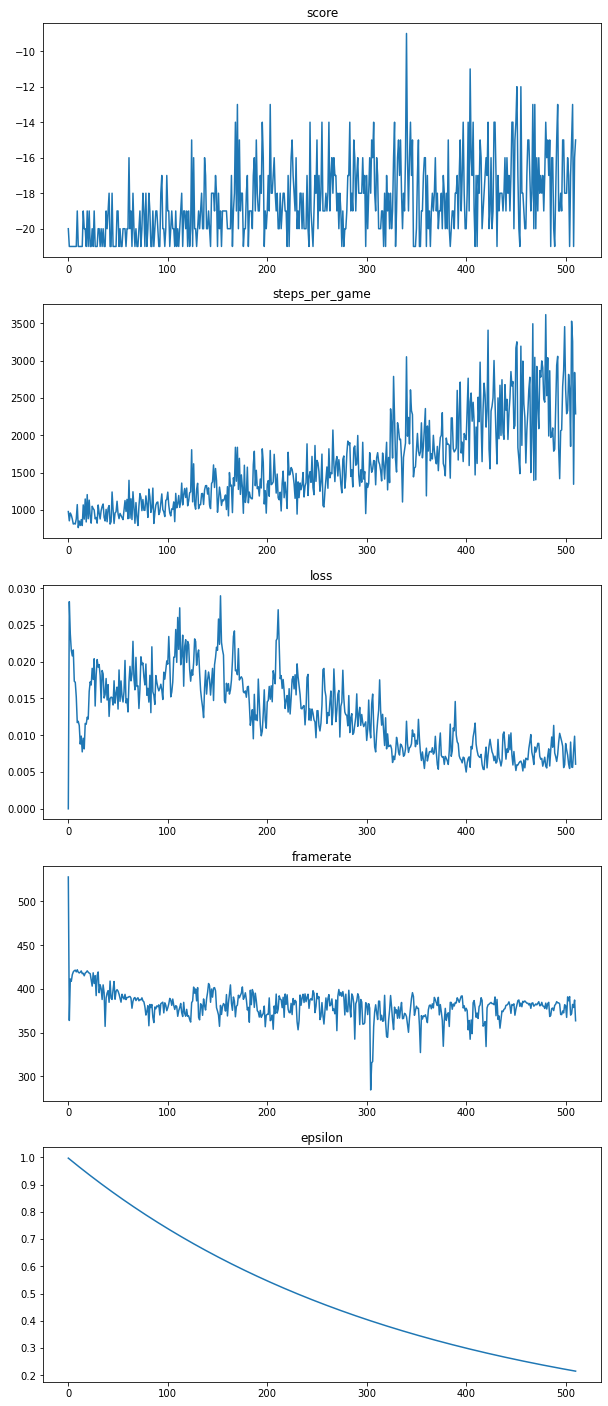

In [ ]:
run_experiment(env, agent,
               train=True,
               runs=500,
#                x_plot='total_steps',
               plot_stats=['score', 'steps_per_game', 'loss', 'framerate', 'epsilon'],
               history=history)

In [51]:
env.reset()

array([0.75294118, 0.        , 0.        , 0.        , 0.43137255,
       0.14901961, 0.        , 0.02745098, 0.27843137, 0.00392157,
       0.23529412, 0.23137255, 0.        , 0.        , 0.        ,
       0.24313725, 1.        , 0.        , 1.        , 0.99215686,
       0.        , 0.08627451, 0.        , 0.09411765, 0.50196078,
       0.1254902 , 0.00392157, 0.3372549 , 0.96862745, 0.3372549 ,
       0.96862745, 0.3372549 , 0.96862745, 0.5254902 , 0.95294118,
       0.96078431, 0.95294118, 0.94117647, 0.94117647, 0.94901961,
       0.94901961, 0.1254902 , 0.1254902 , 0.25098039, 0.25098039,
       0.25098039, 0.7372549 , 0.25490196, 0.74117647, 0.        ,
       0.08627451, 0.42745098, 0.14509804, 0.14509804, 0.23529412,
       0.        , 0.        , 0.        , 0.        , 0.42745098,
       0.42745098, 0.14509804, 0.14509804, 0.75294118, 0.75294118,
       0.75294118, 0.75294118, 0.00392157, 0.75294118, 0.79215686,
       0.96862745, 0.79215686, 0.96862745, 0.79215686, 0.96862

# Vanila DQN

In [7]:
agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=False,
               network_params=network_config,
               exploration_params=exploration_config)
# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

TypeError: __init__() missing 2 required positional arguments: 'stack_size' and 'replay_capacity'

In [ ]:
run_experiment(env, agent, runs=1, render=True, sleep=0.0)
env.close()

In [ ]:
env.frame_skip

In [ ]:
run_experiment(env, agent, train=True, runs=500, plot_stats=['score', 'steps_per_game', 'loss', 'framerate'], history=history)

In [ ]:
run_experiment(env, agent, runs=1, render=True, sleep=0.0)
env.close()

# Double DQN

In [ ]:
network_config['double_q'] = True

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=False,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

# DQN with Priority Replay

In [ ]:
network_config['double_q'] = False
network_config['learning_rate'] = 0.001

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

# Double DQN with Priority Replay

In [ ]:
network_config['double_q'] = True
network_config['learning_rate'] = 0.001

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

In [ ]:
run_experiment(env, agent, runs=1, render=True, sleep=0.0)
env.close()

# Dueling Double DQN with Prioritized Experience Replay

In [ ]:
network_config['double_q'] = True
network_config['dueling_architecture'] = True
network_config['learning_rate'] = 0.001

agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

In [ ]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)

# Noisy Dueling Double DQN with Prioritized Experience Replay

In [6]:
network_config['double_q'] = True
network_config['dueling_architecture'] = True
network_config['learning_rate'] = 0.001
network_config['noisy'] = True

exploration_config['epsilon_init'] = 0.0
exploration_config['epsilon_min'] = 0.0


agent = QAgent(observation_shape=env.observation_space.shape,
               n_actions=env.action_space.n,
               gamma=0.99, # discount of future rewards
               training_start=50, # start training after x number of steps
               training_interval=1, # train every x steps
               batch_size=32,
               priority_replay=True,
               network_params=network_config,
               exploration_params=exploration_config)
history = {}

KeyboardInterrupt: 

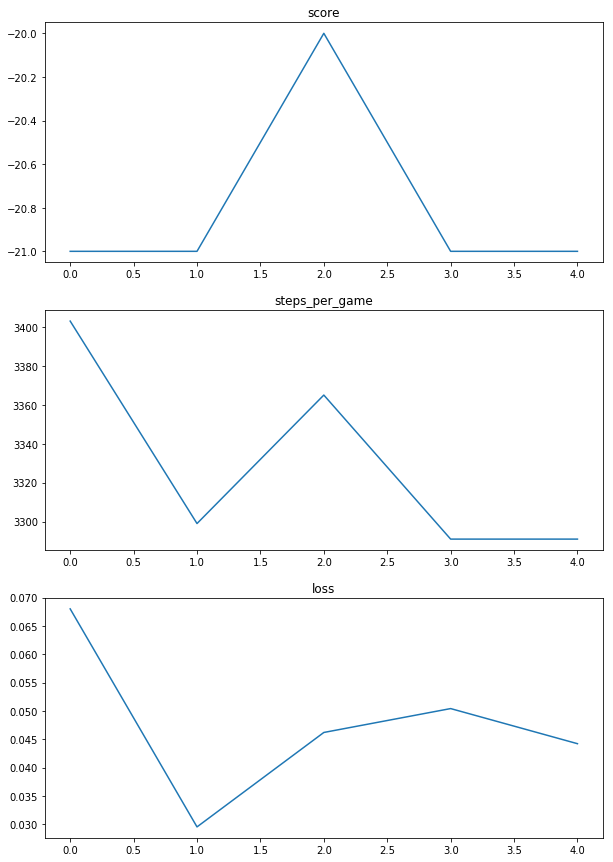

In [7]:
run_experiment(env, agent, runs=500, train=True, plot_stats=['score', 'steps_per_game', 'loss'], history=history)